In [19]:
import numpy as np
import matplotlib.pyplot as plt
import sympy as sp
import CoolProp.CoolProp as cp

In [20]:
Tc = cp.PropsSI('T_critical', 'water')  # [K]
Pc = cp.PropsSI('p_critical', 'water')  # [Pa]
R = 8.314

a = 27 * R ** 2 * Tc ** 2 / (64 * Pc)   # [Pa m^3]
b = R * Tc / (8 * Pc)                   # [m^3]
Vc = 3 * b                              # [m^3]

print(f'a = {a:2e} m^3 Pa')
print(f'b = {b:.2e} m^3')
print(f'Vc = {Vc*1e6:.2f} mL')

a = 5.534228e-01 m^3 Pa
b = 3.05e-05 m^3
Vc = 91.44 mL


### 1c
Løse (14) med Newtons metode mhp. Tc. c = 1 K.

Implementering av løser:

In [21]:
def solve_newton_scalar(f, df, x0, tol=1e-8, maxiter=100):
    """
    Løs en skalar ODE med startverdi x0 med Newtons metode.

    Parametere
    ----------
    f : funksjon f(x) -> float
    df : funksjon f'(x) -> float
    x0 : float
        Startverdi.
    tol : float
        Toleranse (stoppkriterie). Standard satt til 10^-8
    maxiter : int
        Maks antall iterasjoner. Standard satt til 100.

    Returnerer
    ----------
    x : array (n,)
        Løsning av ODE med n punkter. 
        n er enten maxiter eller mindre (gitt av feilkriterie).
    """
    x = np.zeros(maxiter)
    x[0] = x0
    
    for k in range(maxiter-1):
        delta = f(x[k]) / df(x[k])
        x[k+1] = x[k] - delta

        if abs(delta) < tol:
            break

    return x[:k]

Løser lign. (14):

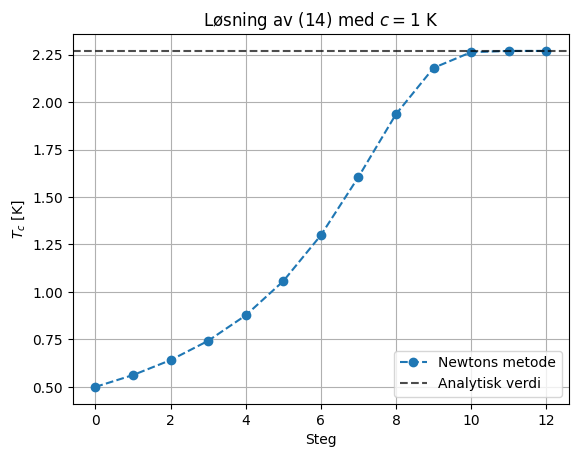

In [22]:
# Bruker c = 1.

def f(T):
    """ Omskrivning av (14). """
    return np.sinh(2./T) ** 2 - 1

def df(T):
    """ Derivasjon av omskrivning av (14). """
    return -2. * np.sinh(4./T) / T ** 2

Tc_anal = 2. / (np.log(1. + np.sqrt(2)))
x = solve_newton_scalar(f, df, x0=.5, tol=1e-14)

# Merker oss at veldig lav toleranse gir konvergens på få antall steg, nice.

plt.plot(x, '--o', label='Newtons metode')
plt.axhline(y=Tc_anal, ls='--', c='k', alpha=0.7, label='Analytisk verdi')
plt.xlabel('Steg')
plt.ylabel('$T_c$ [K]')
plt.title('Løsning av (14) med $c = 1$ K')
plt.legend()
plt.grid()
plt.show()

- Kommenter plott.
- Hvordan påvirker startverdier numerikken. x0 = 0 gir ikke konv. siden sinh(0) - 1 = 0.
- Selv om tol er satt veldig lav, konvergerer metoden på få antall steg.

### 1d

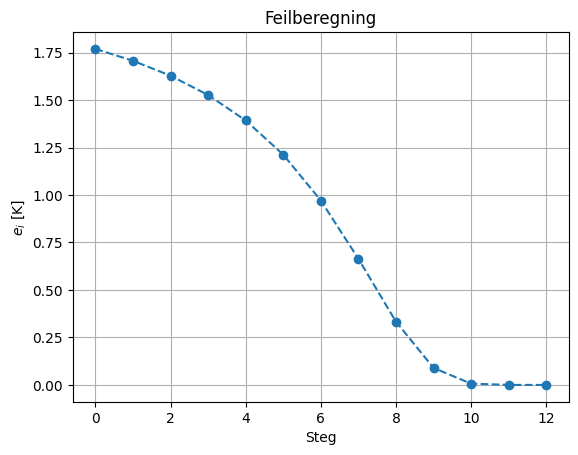

In [23]:
err = np.abs(x - Tc_anal)
plt.plot(err, '--o')
plt.xlabel('Steg')
plt.ylabel('$e_i$ [K]')
plt.title('Feilberegning')
plt.grid()
plt.show()

Konvergensorden qn: 2.0


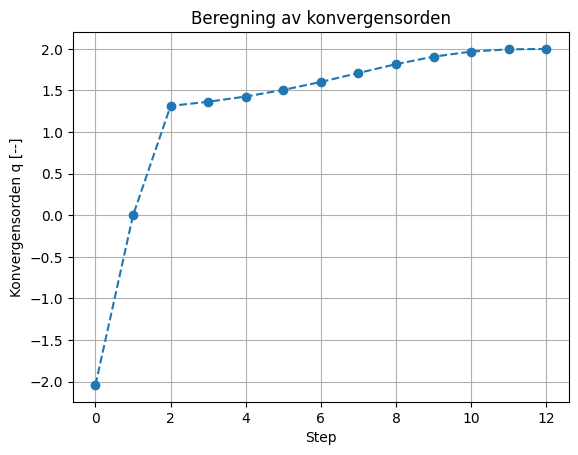

In [24]:
p = [np.log10(err[i]/err[i-1]) / np.log10(err[i-1]/err[i-2]) for i in range(len(err))]

print(f'Konvergensorden qn: {p[-1]:.1f}')

plt.plot(p, '--o')
plt.xlabel('Step')
plt.ylabel('Konvergensorden q [--]')
plt.title('Beregning av konvergensorden')
plt.grid()
plt.show()

Vi ser at vi får q = 2 som svarer til kvadratisk konvergens, som var det vi forventet fra metoden.

### 1e
Vi begynner med å implementere Newtons metode for to variable slik det er beskrevet i appendiks A.

In [25]:
def solve_newton_system(f, jacobi, x0, tol=1e-8, maxiter=100, **kwargs):
    """
    Løser et ligningssystem med Newtons metode gitt f, Jacobimatrisa til f, og startverdi x0.
    Anta systemet består av n ligninger.
    
    Parametere
    ----------
    f : funksjon f(x, **kwargs) -> array (n,) med float
    jacobi : funksjon j(x, **kwargs) -> matrise (n, n) med float
    x0 : array (n,) med float
        Startverdi.
    tol : float
        Toleranse (stoppkriterie). Standard satt til 10^-8
    maxiter : int
        Maks antall iterasjoner. Standard satt til 100.
    kwags : dict
        Keyword argumens som blir sendt videre til f og jacobi.

    Returnerer
    ----------
    x : array (tidssteg, n)
        Løsning av n ODE-er med tidssteg antall tidspunkter. 
        Tidssteg er enten maxiter eller mindre (gitt av feilkriterie).
    """
    n = len(x0)
    x = np.zeros((maxiter, n))
    x[0] = x0

    for k in range(maxiter-1):
        f_k = f(x[k], **kwargs)
        jacobi_k = jacobi(x[k], **kwargs)
        delta = np.linalg.solve(a=jacobi_k, b=-f_k)
        x[k+1] = x[k] + delta

        if np.linalg.norm(delta) < tol:
            break

    return x[:k]


Løser ligningssettet (11), (12).

For å løse lingningssettet (11) og (12), må vi først konstruere et system vi kan løse med Newtons metode. Det innebærer å skrive om ligningene slik at vi får null på høyresiden. Disse kan vi implementere symbolsk i python med `Sympy`. Vi legger til suffiksen '_s' for å indikere hvilke variable som er symboler.

In [26]:
# Definerer symboler
R_s, T_s, Vg_s, Vv_s, a_s, b_s = sp.symbols("R,T,Vg,Vv,a,b")

# (11) omskrevet fra Sophias notater
f1 = R_s * T_s * (
        1. / (Vg_s - b_s) - 1. / (Vv_s - b_s)
    ) - a_s * (
        1. / Vg_s ** 2 - 1. / Vv_s ** 2
    )

# (12) omskrevet fra Sophias notater
f2 = R_s * T_s * (
        sp.log( (Vg_s - b_s) / (Vv_s - b_s) ) / (Vg_s - Vv_s) - 1. / (Vg_s - b_s)
    ) - a_s / Vg_s * (
        1. / Vv_s - 1. / Vg_s
    )

# Gjør f til en vektorvaluert funksjon
f = sp.Matrix([f1, f2])

# Skriver ut systemet
f

Matrix([
[                R*T*(-1.0/(Vv - b) + 1.0/(Vg - b)) - a*(-1.0/Vv**2 + 1.0/Vg**2)],
[R*T*(-1.0/(Vg - b) + log((Vg - b)/(Vv - b))/(Vg - Vv)) - a*(1.0/Vv - 1.0/Vg)/Vg]])

Nå har vi altså systemet vi skal løse symbolsk i python. For at løseren vår kan arbeide sammen med denne, må vi definere en hjelpefunksjon som bytter ut symbolene med tall. Dermed får vi en vektor med flyttall slik vi ønsker. 

For å regne ut Jacobimatrisen er det viktig å holde tunga rett i munnen når man deriverer. Siden vi har implementert systemet med symboler, slipper vi billig unna dette. Vi kan bruke sympy til å regne ut de deriverte. Videre må vi bytte fra symboler til tall, slik vi gjorde med systemet.

In [27]:
def f_func(x, T, a, b):
    """ Bytter fra symboler til tall. """
    Vg, Vv = x
    vector = f.subs([(T_s, T), (a_s, a), (b_s, b), (R_s, R), (Vg_s, Vg), (Vv_s, Vv)])
    return np.asarray([*vector], dtype=float)  # Konverterer til numpy array

jacobi = f.jacobian([Vg_s, Vv_s])

def jacobi_func(x, T, a, b):
    """ Bytter fra symboler til tall. """
    Vg, Vv = x
    matrix = jacobi.subs([(T_s, T), (a_s, a), (b_s, b), (R_s, R), (Vg_s, Vg), (Vv_s, Vv)])
    return np.asarray(matrix, dtype=float)


# Tester at vi får vektor og tall på riktig måte (vilkårlige verier valgt).
print(f_func((0.5, 1), 273, 55e-5, 10))
jacobi_func((0.5, 1), 273, 55e-5, 10)

[13.27157807 -6.51591793]


array([[-25.14047424,  28.02015926],
       [ 12.10863838, -13.51132028]])

Nå kan vi gå frem for å løse systemet for $V_g$ og $V_v$ for temperaturer i intervallet $[273, 647]$. Vi begynner med 
$$
    x_0 = (12.6 \cdot 10^{-3}, 35.7 \cdot 10^{-6})
$$
som er oppgitt i oppgavebeskrivelsen (her i m^3). Dette vil gi konvergens for $T = 274$. For temperaturer $k$, velger vi
$$
    x_0^k = (V_g^{k-1}, V_v^{k-1}),
$$
dvs. løsningen for den foregående temperaturen. Dette gir konvergens for temperaturer over 274.

In [28]:
temp_arr = np.arange(274, 648)

x0 = (12.6e-3, 35.7e-6)  # [m^3]

data = []
for i, t in enumerate(temp_arr):
    if i == 0:
        sol = solve_newton_system(f_func, jacobi_func, x0=x0, tol=1e-14, T=t, a=a, b=b)[-1]
    else:
        sol = solve_newton_system(f_func, jacobi_func, x0=data[-1], tol=1e-14, T=t, a=a, b=b)[-1]
    data.append(sol)

data = np.asarray(data)

Vg = data[:,0]
Vv = data[:,1]

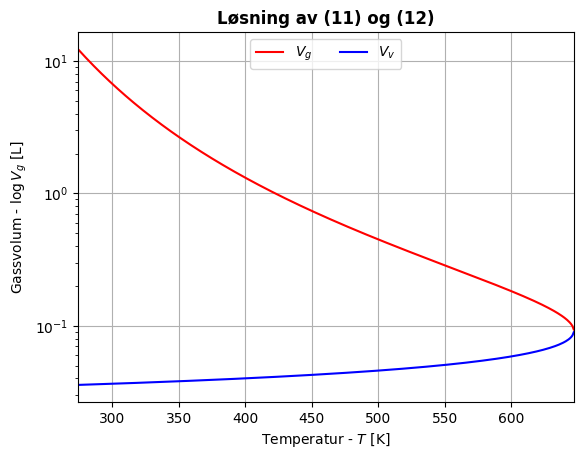

In [29]:
plt.semilogy(temp_arr, Vg*1e3, '-', c='r', label=r'$V_g$')
plt.semilogy(temp_arr, Vv*1e3, '-', c='b', label=r'$V_v$')
plt.legend(loc='upper center', ncol=2)
plt.title('Løsning av (11) og (12)', weight='bold')
plt.xlabel('Temperatur - $T$ [K]')
plt.ylabel(r'Gassvolum - $\logV_g$ [L]')
plt.xlim(274, 647)
plt.grid()
plt.show()

### 1f
For å hente ut eksperimentelle verdier for koeksistenstrykket bruker vi `cp.PropsSI('P', 'T|twophase', 274, 'Q', 0, 'Water')`. Dette er en funksjon som gir ut trykket i Pascal. Argumentet `T|twophase` forteller at vi befinner oss på koeksistenskurven. `Q` forteller om vi har mettet væske eller gass. Dette har ingen betydning langs koeksistenskurven, men vi kan bruke denne til å finne fordampningsvarmen til vann. `Q = 1` svarer til væskefase, og `Q = 0` svarer til gassfasen. Vi bruker at fordampningsvarmen er gitt ved differansen mellom entalpien til vannet i væske- og gassfasen langs koeksistenskurven.

In [30]:
vapor_pressure_exp = np.asarray([cp.PropsSI('P', 'T|twophase', t, 'Q', 0, 'Water') for t in temp_arr])

latent_heat_vaporization = np.asarray([
    cp.PropsSI('H', 'T|twophase', t, 'Q', 1, 'Water') - cp.PropsSI('H', 'T|twophase', t, 'Q', 0, 'Water') for t in temp_arr
])  # [J/kg]

molar_mass_water = 18.01528e-3  # [kg/mol]
latent_heat_vaporization *= molar_mass_water  # [J/mol]

Nå kan vi ta for oss å løse ligning (13). Vi bruker Eulers metode for å løse ligningen. Startverdien velges til $P_0 = P(T=274) \approx 650$ Pa. Siden vi har alle heltallstemperatuer mellom 274 og 647, er $dT = 1$.

In [31]:
def dp(T, L, Vg, Vv):
    return L / (T * (Vg - Vv))

vapor_pressure_estimation = np.zeros_like(temp_arr)
vapor_pressure_estimation[0] = 700.  # Pa

for i in range(len(temp_arr)-1):
    delta = dp(temp_arr[i], latent_heat_vaporization[i], Vg[i], Vv[i])
    vapor_pressure_estimation[i+1] = vapor_pressure_estimation[i] + delta

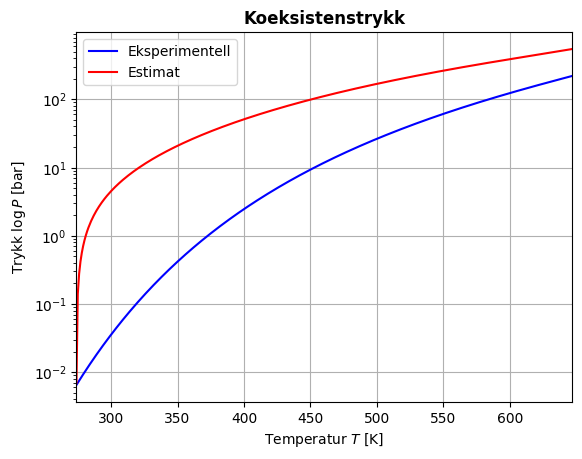

In [32]:
plt.semilogy(temp_arr, vapor_pressure_exp*1e-5, c='b', label='Eksperimentell')
plt.semilogy(temp_arr, vapor_pressure_estimation*1e-5, c='r', label='Estimat')
plt.ylabel('Trykk $\log P$ [bar]')
plt.xlabel('Temperatur $T$ [K]')
plt.title('Koeksistenstrykk', weight='bold')
plt.legend(loc='upper left')
plt.xlim(274, 647)
plt.grid()
plt.show()

Diskuter temperaturavhengigheten til avviket.

### 1g

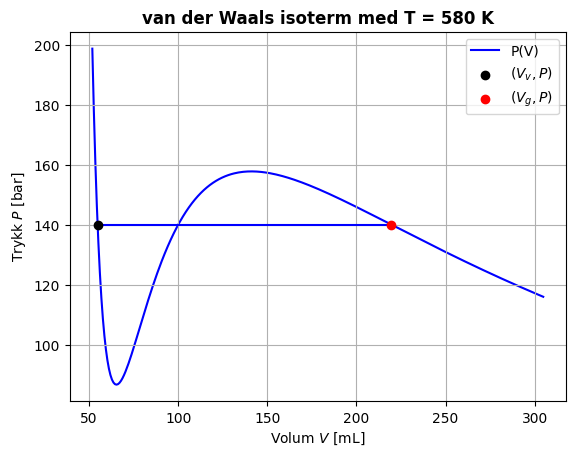

In [33]:
def p_van_der_waals(V, t):
    """ van der Waals tilstandsligning (8). """
    return R * t / (V - b) - a / V ** 2

temp = 580  # [K]
temp_index = temp - 274
vol_arr = np.linspace(1.7*b, 10*b, 300)  # [m^3]

Vv_t = Vv[temp_index]
Vg_t = Vg[temp_index]

p_v = p_van_der_waals(vol_arr, temp)  # [Pa]
p_Vv = p_van_der_waals(Vv_t, temp)    # [Pa]
p_Vg = p_van_der_waals(Vg_t, temp)    # [Pa]

plt.plot(vol_arr*1e6, p_v*1e-5, c='b', zorder=1, label='P(V)')
plt.hlines(y=p_Vv*1e-5, color='b', zorder=2, xmin=54, xmax=219)
plt.scatter(Vv_t*1e6, p_Vv*1e-5, c='k', zorder=3, label='($V_v, P$)')
plt.scatter(Vg_t*1e6, p_Vg*1e-5, c='r', zorder=3, label='($V_g, P$)')

plt.xlabel('Volum $V$ [mL]')
plt.ylabel('Trykk $P$ [bar]')
plt.title(f'van der Waals isoterm med T = {temp:.0f} K', weight='bold')
plt.legend()
plt.grid()
plt.show()

Forklar kort fysisk hva som skjer på intervallet $[V_v, V_g]$.

### 1h

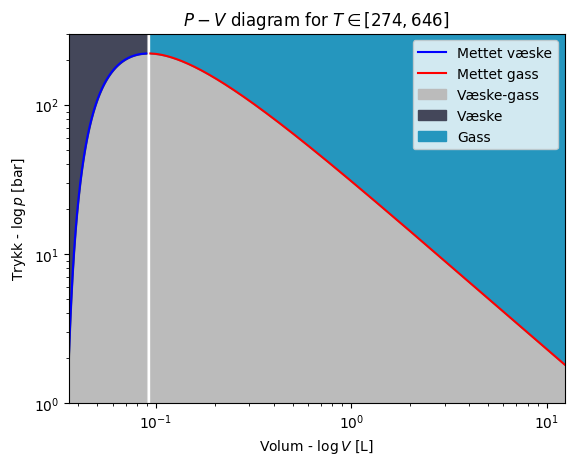

In [34]:
p_Vv = p_van_der_waals(Vv, temp_arr)*1e-5  # [bar]
p_Vg = p_van_der_waals(Vg, temp_arr)*1e-5  # [bar]

plt.autoscale(tight=True)

plt.loglog(Vv*1e3, p_Vv, c='b', zorder=2, label='Mettet væske')
plt.loglog(Vg*1e3, p_Vg, c='r', zorder=2, label='Mettet gass')
plt.fill_between(Vv*1e3, p_Vv, 1, zorder=1, color='#bbbbbb', label='Væske-gass')
plt.fill_between(Vg*1e3, p_Vg, 1, zorder=1, color='#bbbbbb')
plt.fill_between(Vv*1e3, p_Vv, 300, zorder=1, color='#44475a', label='Væske')
plt.fill_between(Vg*1e3, p_Vg, 300, zorder=1, color='#2596be', label='Gass')

plt.xlabel(r'Volum - $\log V$ [L]')
plt.ylabel('Trykk - $\log p$ [bar]')
plt.title('$P-V$ diagram for $T \in[274,646]$')
plt.legend()
plt.show()

Diskuter figuren kort.